In [1]:
!pip install gdown
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.2 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=98c7c901a11af386bf3d79b3989cadb9f09656beed82a347fa6d3025ce02a70a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d71cd75faf101c7af330046fd3edb0eb9a131b54b91641070a39bc3369d04d62
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import torchmetrics
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [4]:
# https://github.com/albumentations-team/autoalbument/blob/master/examples/pascal_voc/dataset.py
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask


trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Sharpen(),
    A.CoarseDropout(max_holes=5, max_height=int(384 * 0.1), max_width=int(384 * 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


train_dataset =  PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_transform)

100%|██████████| 1999639040/1999639040 [01:02<00:00, 32197533.97it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


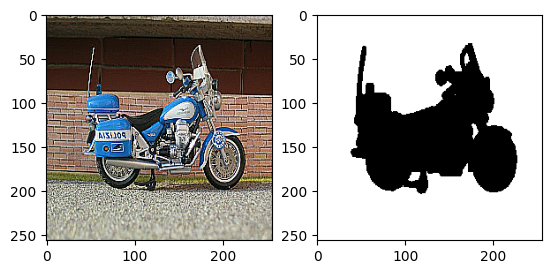

In [5]:
image, mask = train_dataset.__getitem__(800)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0)) 
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')

plt.show()

In [6]:
#metrics
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target 

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8
n_workers = 2
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = smp.create_model("DeepLabV3Plus", "timm-efficientnet-b4", "imagenet", 3, 21).to(device)

#loss : https://smp.readthedocs.io/en/stable/losses.html
# criterion = nn.CrossEntropyLoss()    JaccardLoss    TverskyLoss LovaszLoss
criterion = smp.losses.DiceLoss(mode="multiclass", classes=21) #diceloss = 1-dicescore

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 50

train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 2


In [12]:
for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y = y.argmax(dim=-1)  # Convert (B, 256, 256, 21) -> (B, 256, 256)
        # print(y.shape)
        y_hat = model(x) #(B, C, H, W)
        # print(y_hat.shape)
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

        mIoU = torch.mean(iou_class) #mean vector 21D
        mDice = torch.mean(dice_class) #mean vector 21D

    print("EP {}, train loss = {} IoU = {}, dice = {}".format(ep, train_loss_meter.avg, mIoU, mDice))
    
    if ep >= 48:
        torch.save(model.state_dict(), "modelDeepLab_ep_{}.pth".format(ep))

100%|██████████| 183/183 [02:20<00:00,  1.30it/s]


EP 1, train loss = 0.3902177838354163 IoU = 0.07771876454353333, dice = 0.123985655605793


100%|██████████| 183/183 [02:12<00:00,  1.38it/s]


EP 2, train loss = 0.3189672506897827 IoU = 0.1837974488735199, dice = 0.2747582197189331


100%|██████████| 183/183 [02:07<00:00,  1.43it/s]


EP 3, train loss = 0.2701324305084885 IoU = 0.2945592403411865, dice = 0.4160175323486328


100%|██████████| 183/183 [02:13<00:00,  1.37it/s]


EP 4, train loss = 0.23386439941619916 IoU = 0.37056997418403625, dice = 0.5100618004798889


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


EP 5, train loss = 0.20693489347324998 IoU = 0.4353933334350586, dice = 0.5871469378471375


100%|██████████| 183/183 [02:08<00:00,  1.43it/s]


EP 6, train loss = 0.18796221374488267 IoU = 0.4724974036216736, dice = 0.6261622905731201


100%|██████████| 183/183 [02:06<00:00,  1.44it/s]


EP 7, train loss = 0.18088738009577893 IoU = 0.4993385374546051, dice = 0.651387095451355


100%|██████████| 183/183 [02:08<00:00,  1.43it/s]


EP 8, train loss = 0.1736095092905675 IoU = 0.5155978798866272, dice = 0.6673448085784912


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


EP 9, train loss = 0.1628193042846651 IoU = 0.5433234572410583, dice = 0.6903979778289795


100%|██████████| 183/183 [02:21<00:00,  1.29it/s]


EP 10, train loss = 0.15762416407710217 IoU = 0.56169193983078, dice = 0.706200122833252


100%|██████████| 183/183 [02:22<00:00,  1.29it/s]


EP 11, train loss = 0.15009704637315754 IoU = 0.5735633373260498, dice = 0.7173001766204834


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EP 12, train loss = 0.14534573014723798 IoU = 0.5869438648223877, dice = 0.7291057109832764


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EP 13, train loss = 0.14016726633401516 IoU = 0.5974776744842529, dice = 0.7375460267066956


100%|██████████| 183/183 [02:23<00:00,  1.27it/s]


EP 14, train loss = 0.13681501439197466 IoU = 0.611229419708252, dice = 0.7487040758132935


100%|██████████| 183/183 [02:23<00:00,  1.27it/s]


EP 15, train loss = 0.1348746919322535 IoU = 0.6080583930015564, dice = 0.7461769580841064


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EP 16, train loss = 0.1305660397587904 IoU = 0.6318066120147705, dice = 0.7651616334915161


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EP 17, train loss = 0.12877049005992425 IoU = 0.6327201724052429, dice = 0.7659386992454529


100%|██████████| 183/183 [02:12<00:00,  1.38it/s]


EP 18, train loss = 0.1271068512212709 IoU = 0.6476687788963318, dice = 0.7786067724227905


100%|██████████| 183/183 [02:18<00:00,  1.32it/s]


EP 19, train loss = 0.12343529890713796 IoU = 0.6545041799545288, dice = 0.7825618982315063


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


EP 20, train loss = 0.11989409234272978 IoU = 0.6665042042732239, dice = 0.7918000221252441


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EP 21, train loss = 0.12250518754043214 IoU = 0.6585697531700134, dice = 0.7862670421600342


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EP 22, train loss = 0.11560139369443466 IoU = 0.6790305376052856, dice = 0.8013848662376404


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


EP 23, train loss = 0.1135772877968237 IoU = 0.6814096570014954, dice = 0.8030468225479126


100%|██████████| 183/183 [02:20<00:00,  1.31it/s]


EP 24, train loss = 0.11058216739466281 IoU = 0.6815881729125977, dice = 0.8035516142845154


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EP 25, train loss = 0.11391970975314333 IoU = 0.6966191530227661, dice = 0.8147053718566895


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EP 26, train loss = 0.11145157672342706 IoU = 0.6983739137649536, dice = 0.8163077235221863


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EP 27, train loss = 0.11072617877132254 IoU = 0.7065635919570923, dice = 0.8220674395561218


100%|██████████| 183/183 [02:11<00:00,  1.40it/s]


EP 28, train loss = 0.10253043089041619 IoU = 0.7048241496086121, dice = 0.8208523988723755


100%|██████████| 183/183 [02:12<00:00,  1.38it/s]


EP 29, train loss = 0.1048277933863017 IoU = 0.7129152417182922, dice = 0.8262450695037842


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EP 30, train loss = 0.10176434497160664 IoU = 0.710384726524353, dice = 0.8241883516311646


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EP 31, train loss = 0.10455086212503455 IoU = 0.7232047319412231, dice = 0.8337197303771973


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EP 32, train loss = 0.10173351075398467 IoU = 0.7141069769859314, dice = 0.8271148204803467


100%|██████████| 183/183 [02:25<00:00,  1.26it/s]


EP 33, train loss = 0.10222828243680991 IoU = 0.7179821133613586, dice = 0.8304948210716248


100%|██████████| 183/183 [02:21<00:00,  1.29it/s]


EP 34, train loss = 0.10134874580458539 IoU = 0.7355756163597107, dice = 0.842444121837616


100%|██████████| 183/183 [02:12<00:00,  1.38it/s]


EP 35, train loss = 0.09918498381198755 IoU = 0.7325868010520935, dice = 0.8397010564804077


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EP 36, train loss = 0.09833421780030584 IoU = 0.737041175365448, dice = 0.843830406665802


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


EP 37, train loss = 0.09923953288158432 IoU = 0.7480936646461487, dice = 0.8508164882659912


100%|██████████| 183/183 [02:16<00:00,  1.34it/s]


EP 38, train loss = 0.0952013880523339 IoU = 0.7417709827423096, dice = 0.8472971320152283


100%|██████████| 183/183 [02:13<00:00,  1.37it/s]


EP 39, train loss = 0.09766121270755927 IoU = 0.7455704212188721, dice = 0.849554717540741


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EP 40, train loss = 0.09348152994173146 IoU = 0.7513914704322815, dice = 0.8538018465042114


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EP 41, train loss = 0.090745270964715 IoU = 0.7494475245475769, dice = 0.8524097204208374


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


EP 42, train loss = 0.09132010564004463 IoU = 0.7543281316757202, dice = 0.855212390422821


100%|██████████| 183/183 [02:16<00:00,  1.34it/s]


EP 43, train loss = 0.08978041413092548 IoU = 0.7572458386421204, dice = 0.8573927283287048


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EP 44, train loss = 0.09339857424095355 IoU = 0.7642747163772583, dice = 0.8620211482048035


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EP 45, train loss = 0.0879639122289061 IoU = 0.7635452151298523, dice = 0.8613269329071045


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EP 46, train loss = 0.0871836693825129 IoU = 0.7639128565788269, dice = 0.8616364002227783


100%|██████████| 183/183 [02:19<00:00,  1.31it/s]


EP 47, train loss = 0.08360198932022997 IoU = 0.7601518630981445, dice = 0.8589991927146912


100%|██████████| 183/183 [02:26<00:00,  1.25it/s]


EP 48, train loss = 0.08659886863957988 IoU = 0.7687766551971436, dice = 0.8656569123268127


100%|██████████| 183/183 [02:18<00:00,  1.32it/s]


EP 49, train loss = 0.08814359082753867 IoU = 0.7680467963218689, dice = 0.8646266460418701


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EP 50, train loss = 0.08641277280091587 IoU = 0.7683342695236206, dice = 0.8649381399154663


In [13]:
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y = y.argmax(dim=-1)  # Convert (B, 256, 256, 21) -> (B, 256, 256)

        y_hat = model(x)
        y_hat = y_hat.squeeze(1)
        y_hat_mask = y_hat.argmax(dim=1)
        
        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, 21)
        test_intersection_meter.update(intersection)
        test_union_meter.update(union)
        test_target_meter.update(target)
        
    iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    dice_class = 2*test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    mIoU = torch.mean(iou_class)
    mDice = torch.mean(dice_class)
        
print("TEST: IoU = {}, dice = {}".format(mIoU, mDice))

100%|██████████| 182/182 [01:58<00:00,  1.54it/s]

TEST: IoU = 0.6098151803016663, dice = 0.7420175075531006


background
horse


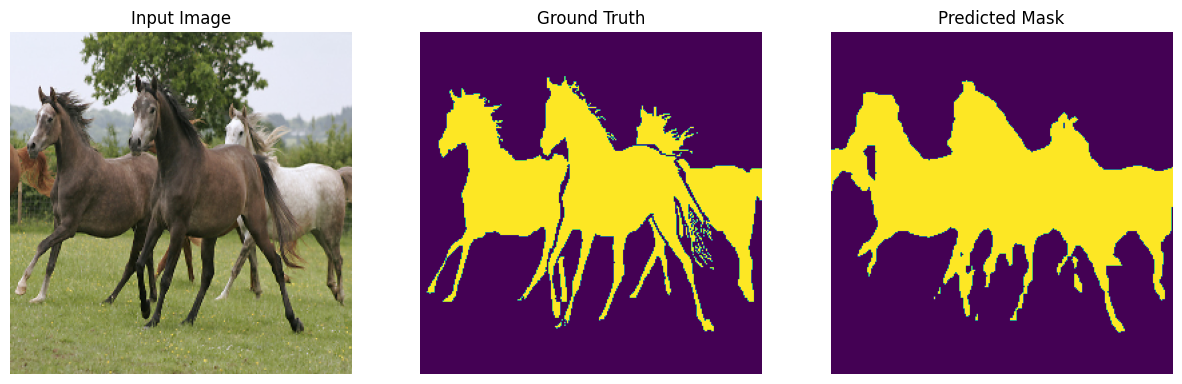

background
train
tv/monitor


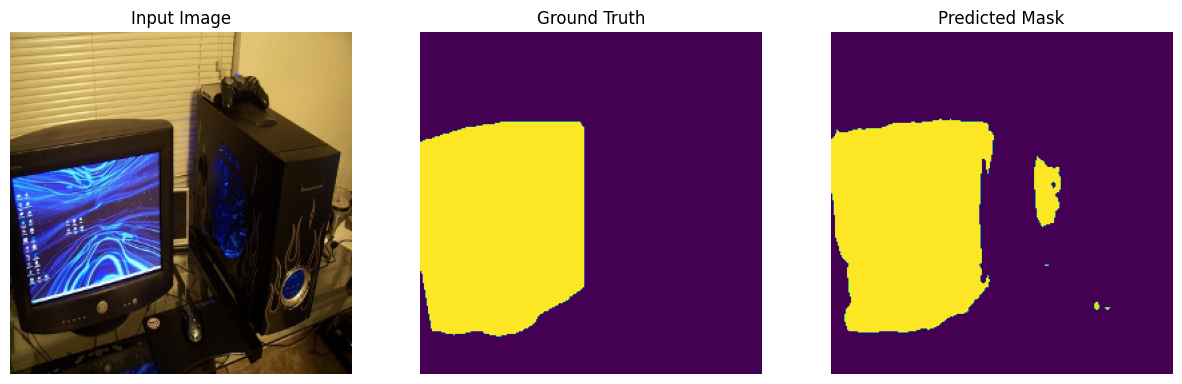

background
bus


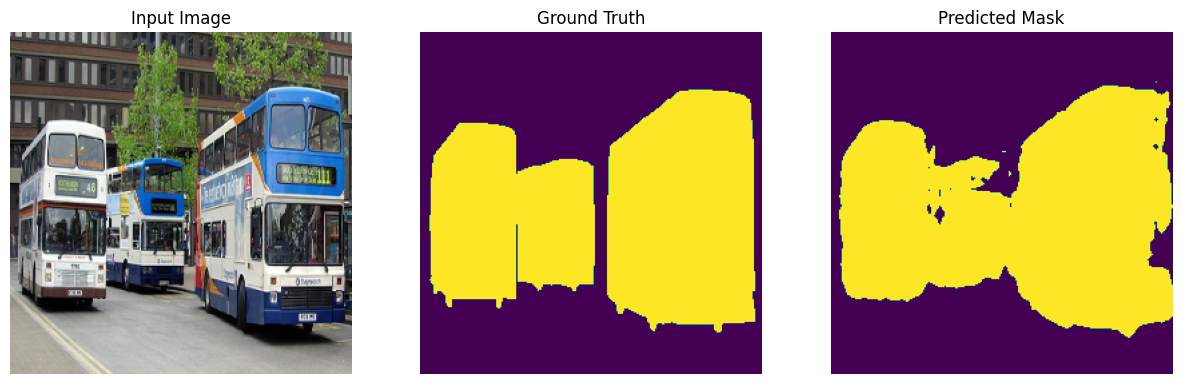

background
person
sofa


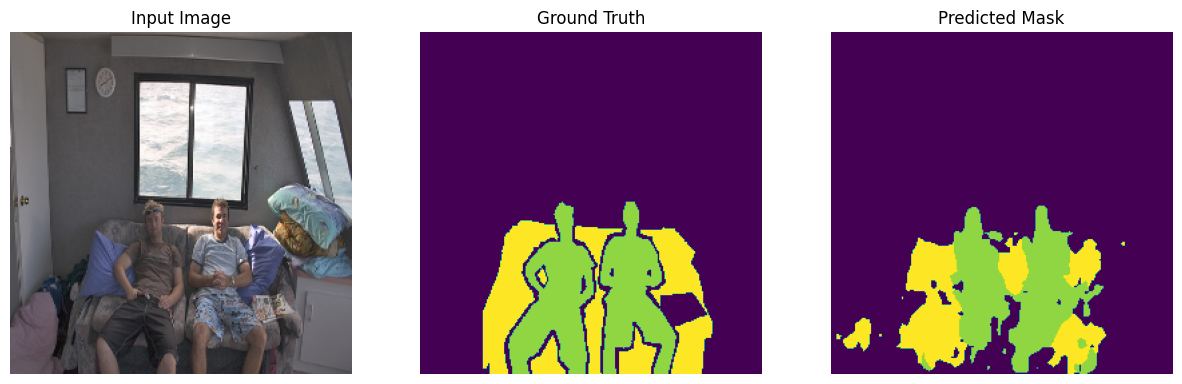

background
cow
sheep


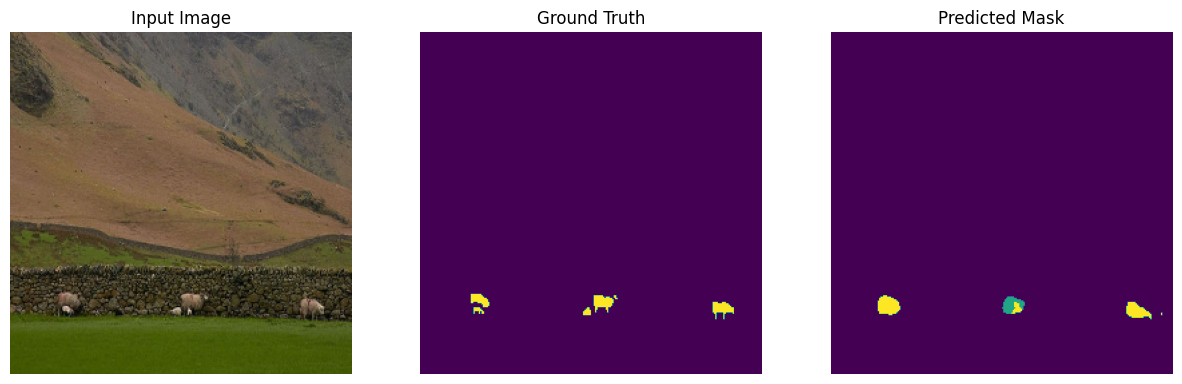

background
train


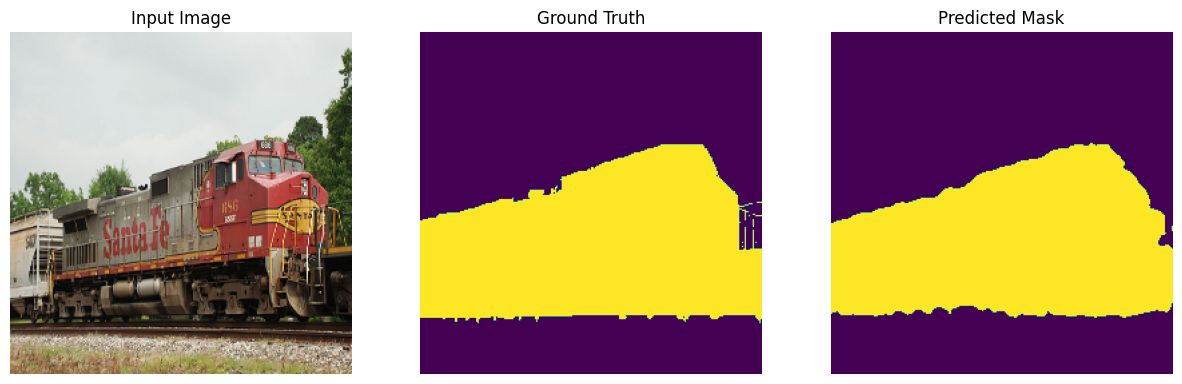

background
person


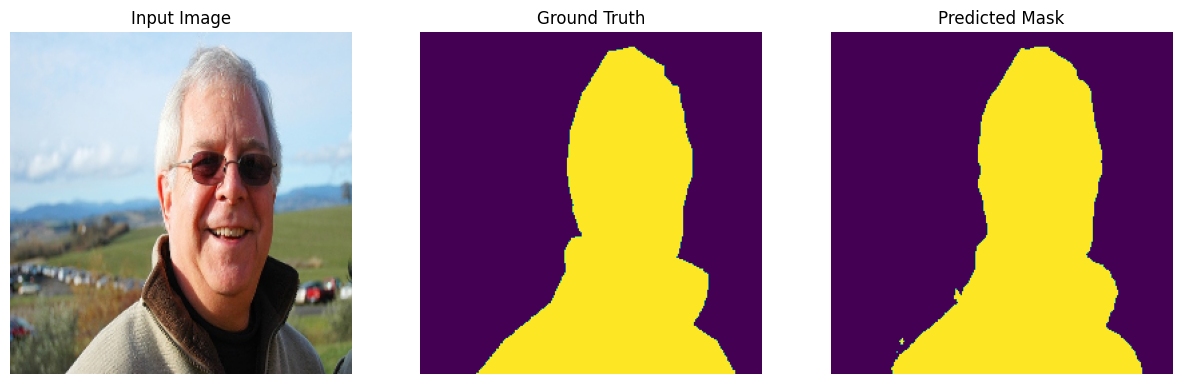

background
train


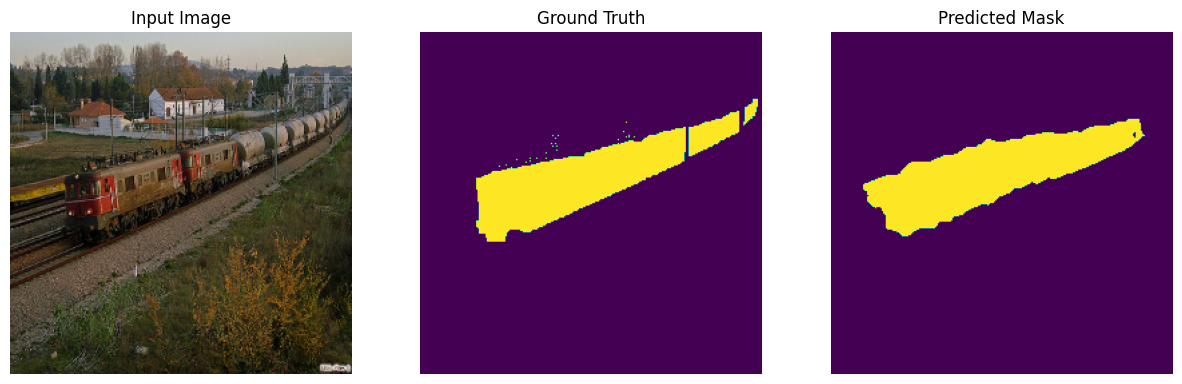

background
motorbike
person


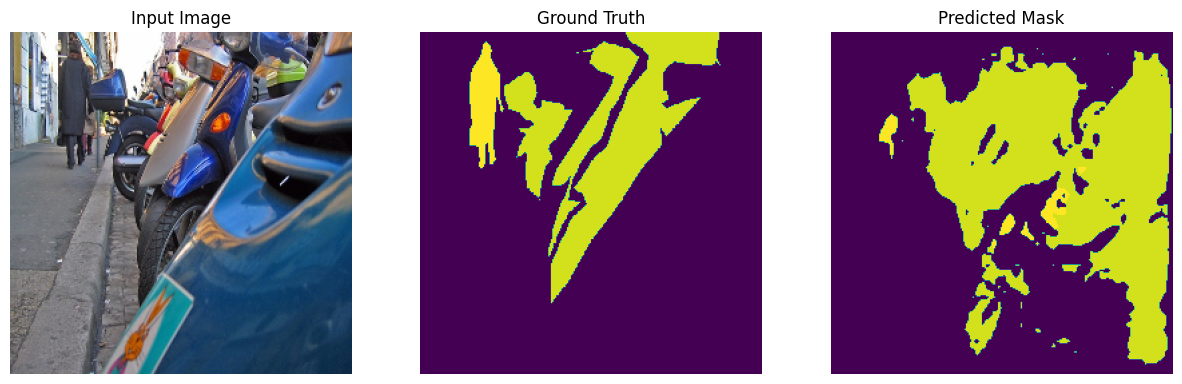

background
bird


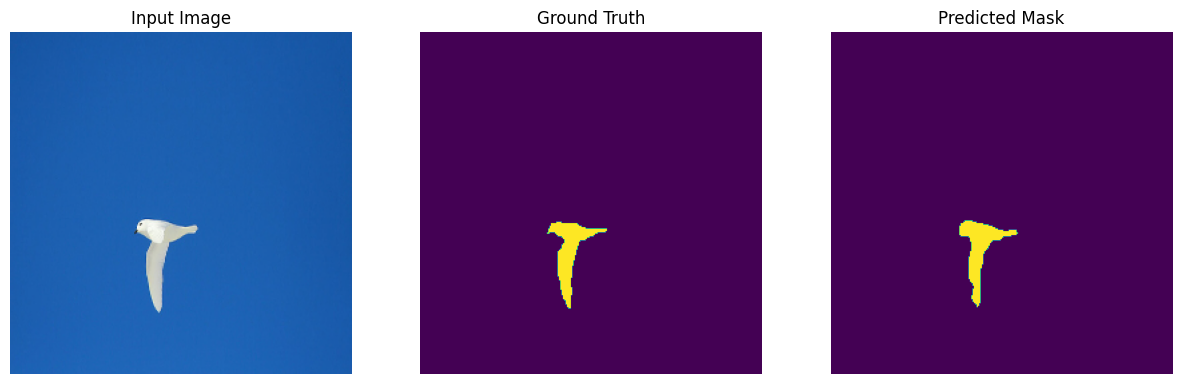

background
train


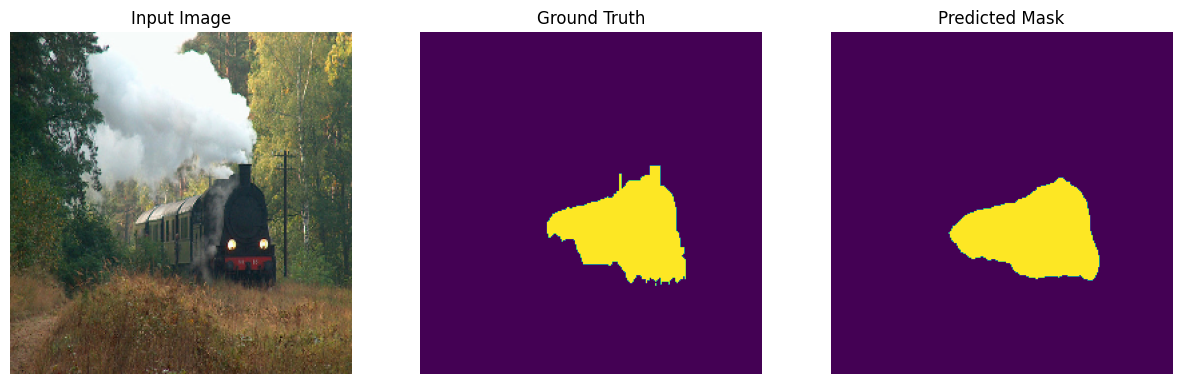

background
aeroplane


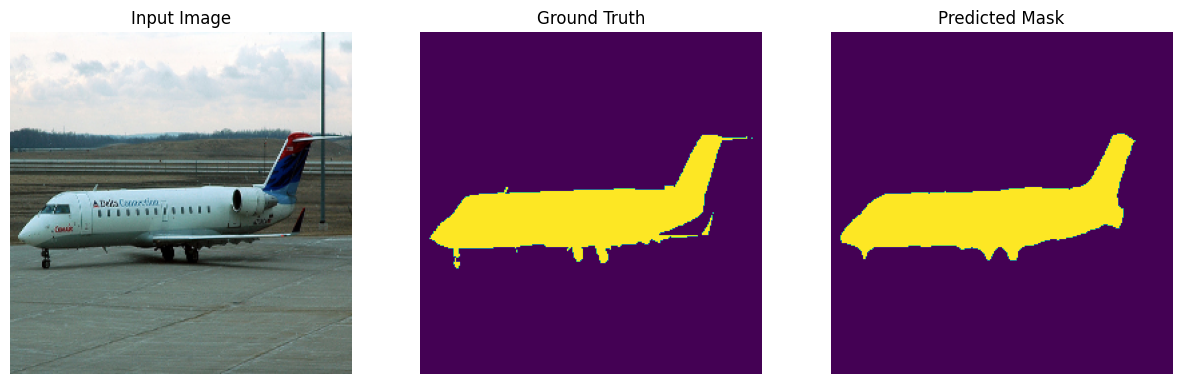

background
aeroplane
bird


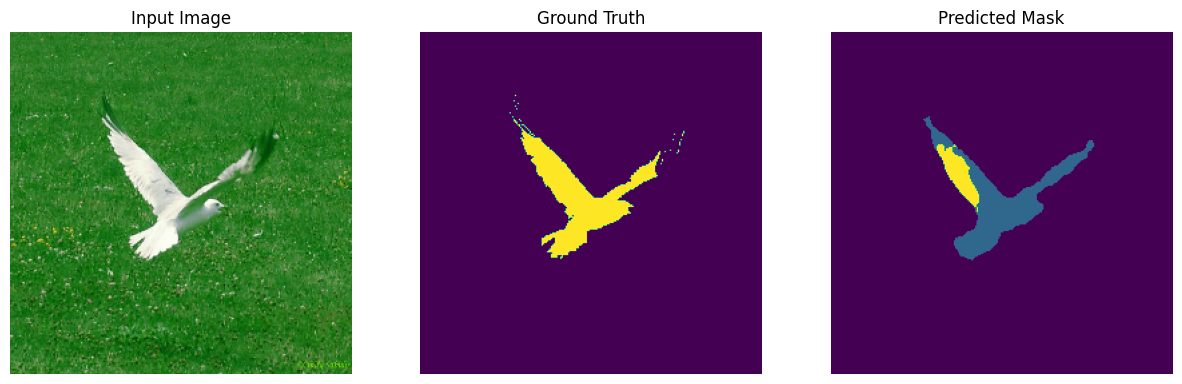

background
car


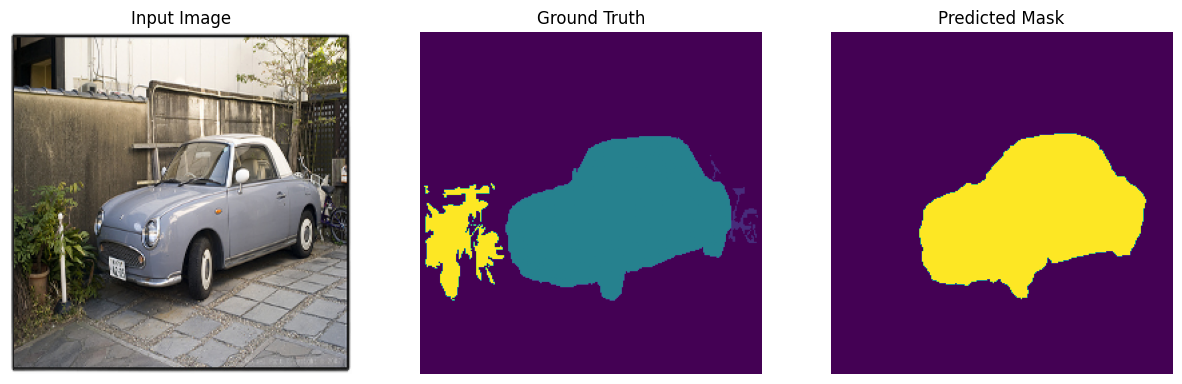

background
boat


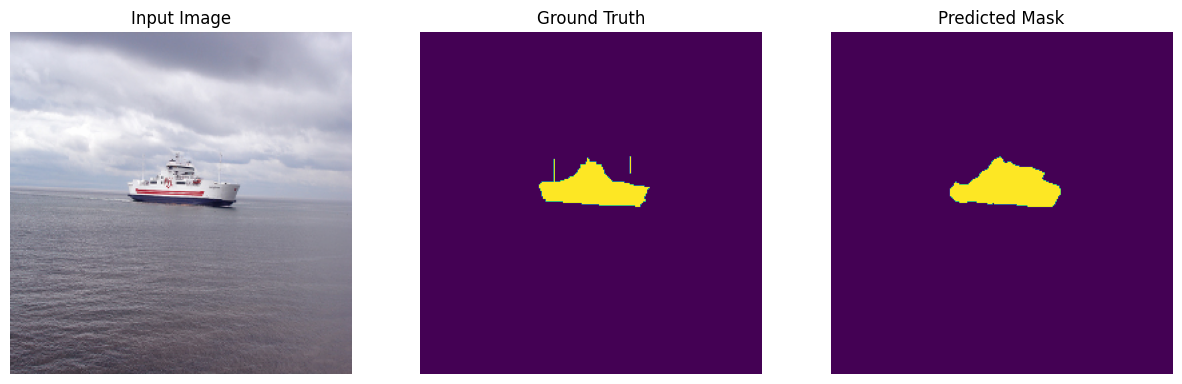

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

for i in range(15):
    # Randomly select an image and its ground truth from the test dataset
    id = random.randint(0, len(test_dataset) - 1)
    
    with torch.no_grad():
        model.eval()
        x, y = test_dataset.__getitem__(id)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y_predict = model(x).argmax(dim=1).squeeze().cpu().numpy()  # Get predicted mask (2D array)
        
        # Print class labels for the predicted mask (if any)
        for class_id in np.unique(y_predict):
            print(VOC_CLASSES[class_id])

    # Convert the input image to a numpy array for visualization (if it's a tensor)
    x = x.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for RGB
    
    # Convert ground truth (if y is one-hot encoded, apply argmax to get the class labels)
    ground_truth = y.squeeze().cpu().numpy()  # (H, W, 21) -> (H, W)
    ground_truth = np.argmax(ground_truth, axis=-1)  # Apply argmax to reduce to (H, W)
    
    # Define the mean and std values used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Unnormalize: multiply by std and add mean for each channel
    unnormalized_image = x * std + mean  # Unnormalize the image

    # Clip values to [0, 1] to make sure they are within the valid range for displaying
    unnormalized_image = np.clip(unnormalized_image, 0, 1)
    
    # Plot the input image, ground truth, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image (unnormalized)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth (2D array with class labels)
    axes[1].imshow(ground_truth)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    # Predicted Mask (2D array with class labels)
    axes[2].imshow(y_predict)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()


background
diningtable
person
potted plant


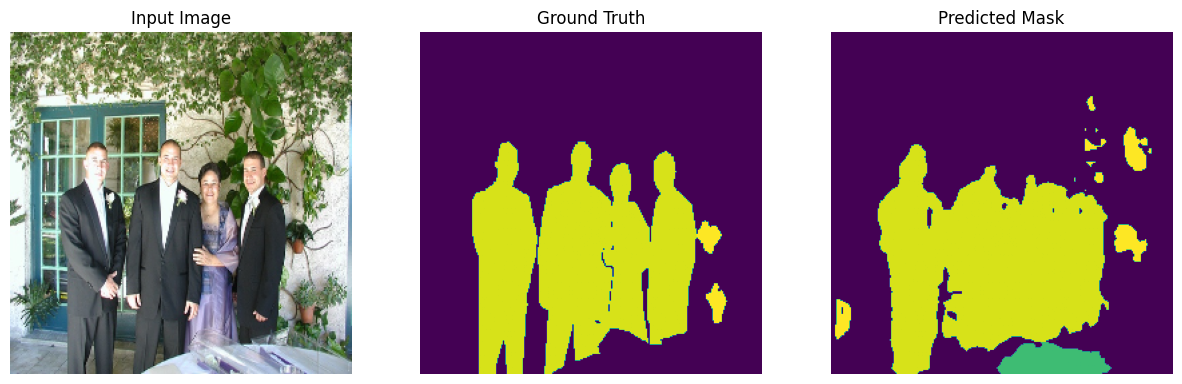

background
chair
diningtable
sofa


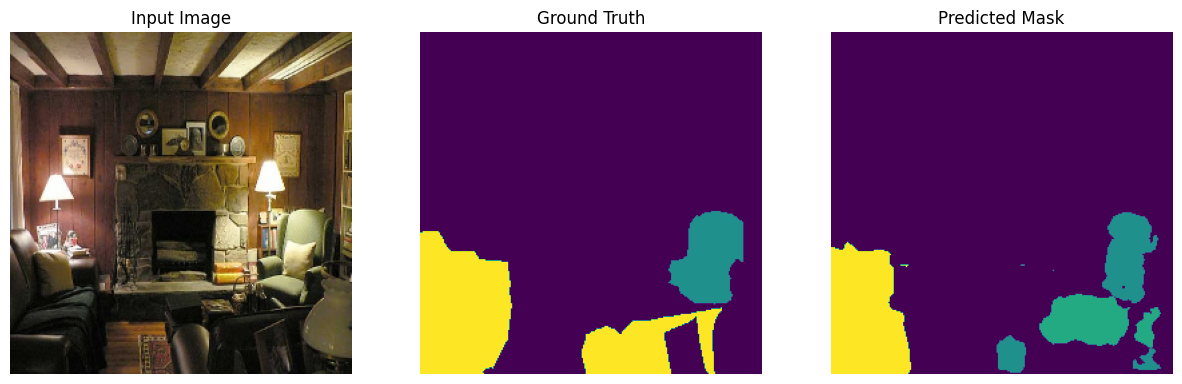

background
cat


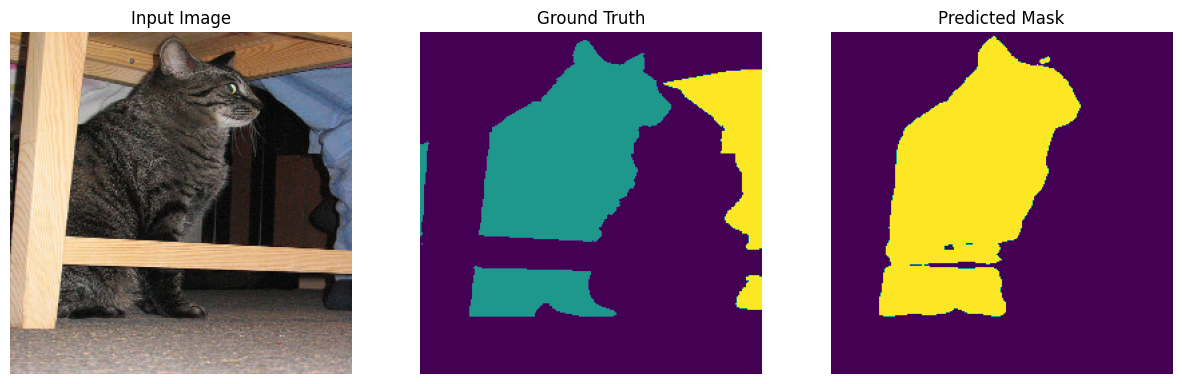

background
cow
sheep


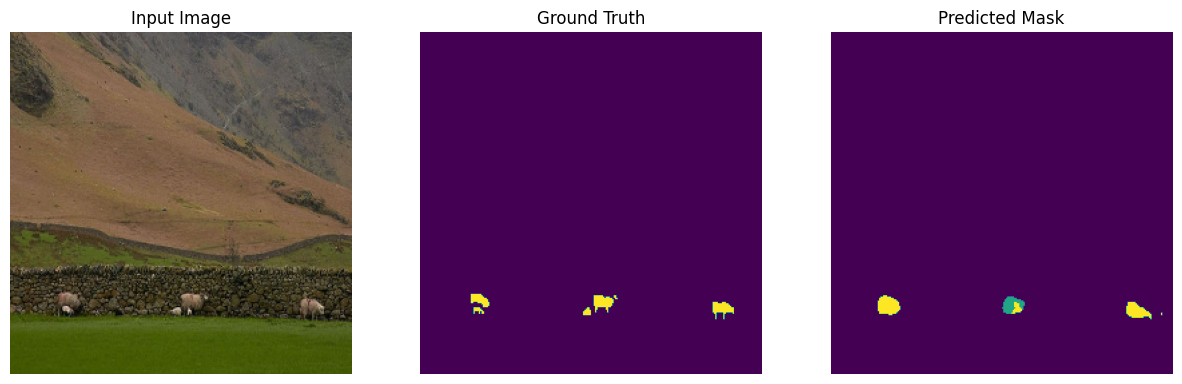

background
chair
person
train


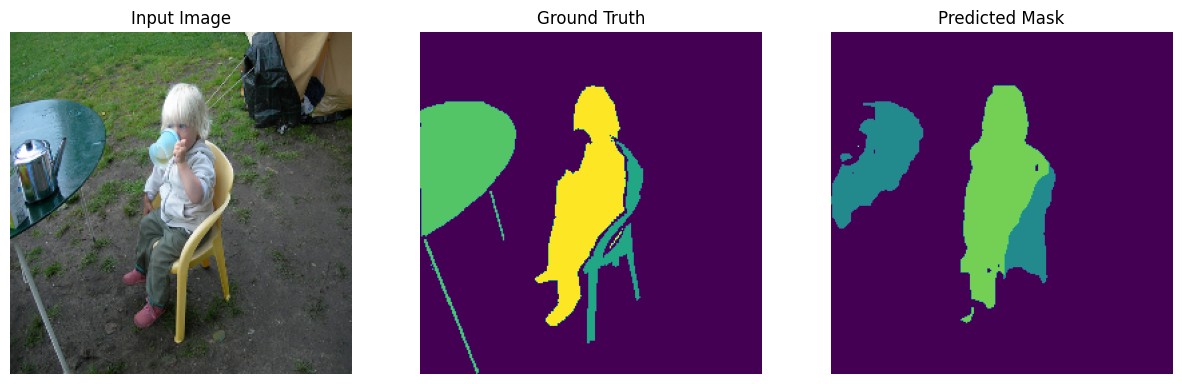

background
potted plant


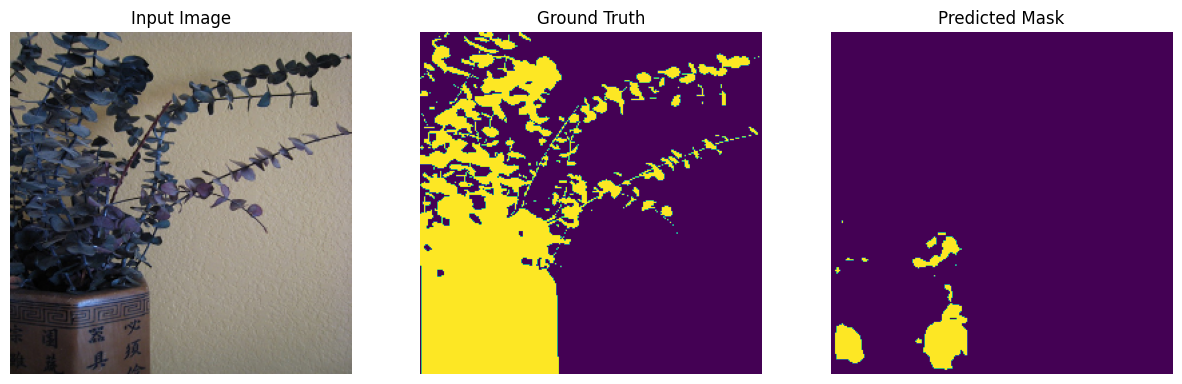

background
cow
horse


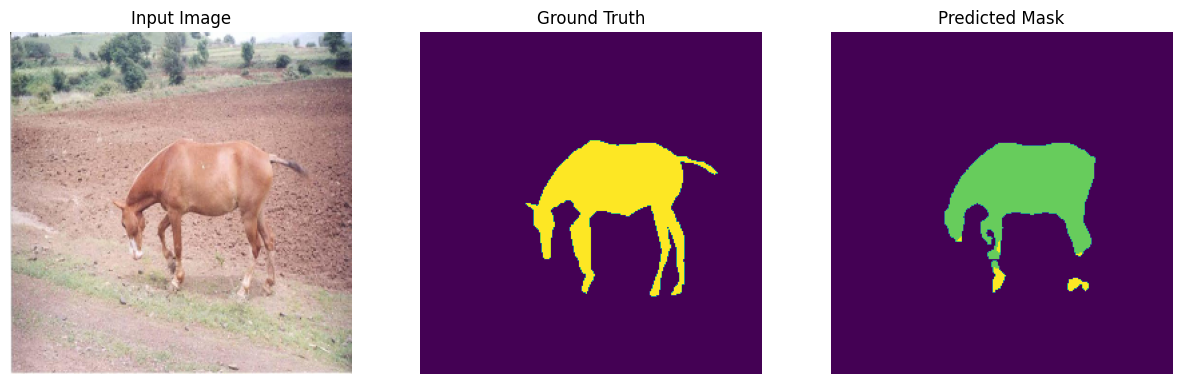

background
chair
diningtable
potted plant


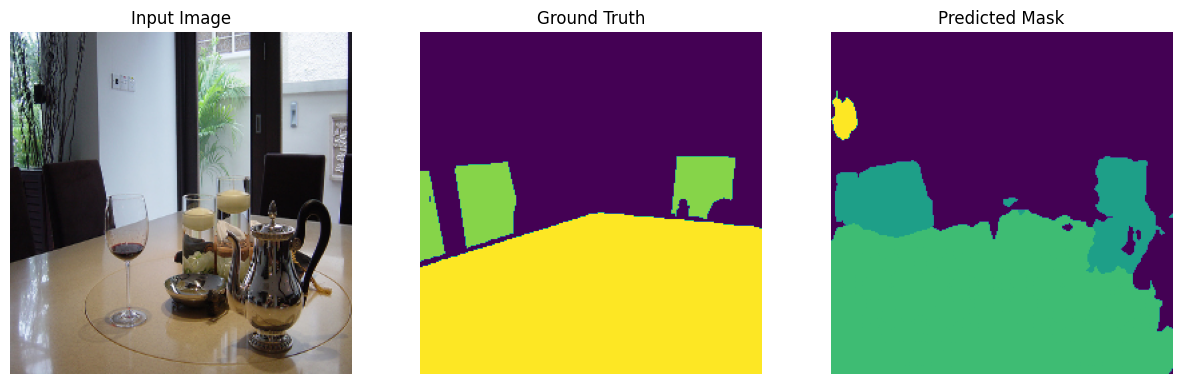

background
cow
horse
train


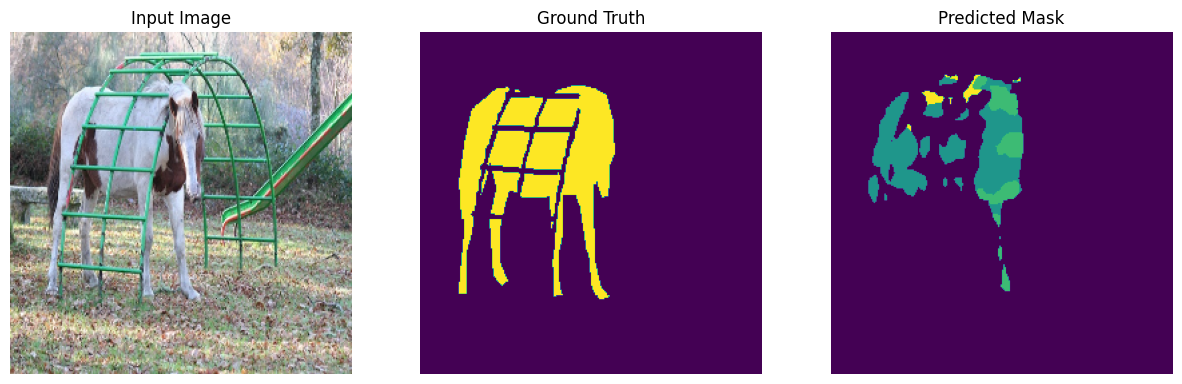

background
car
person


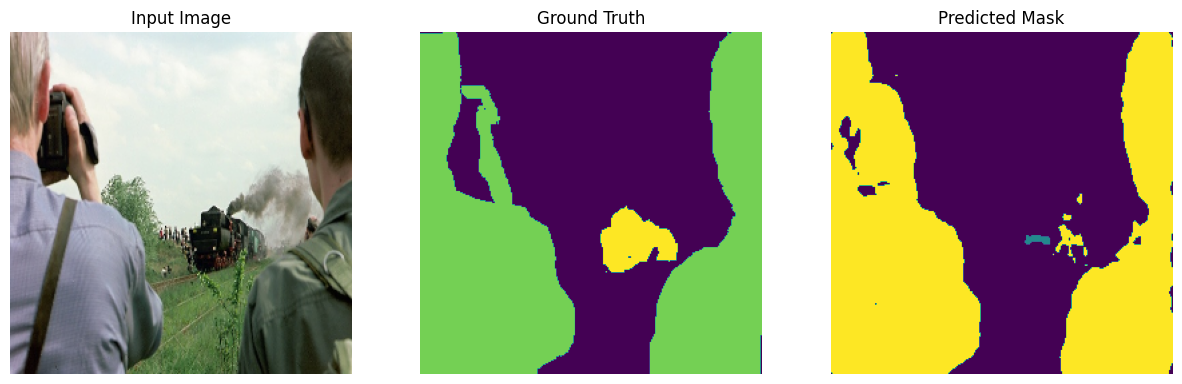

background
boat


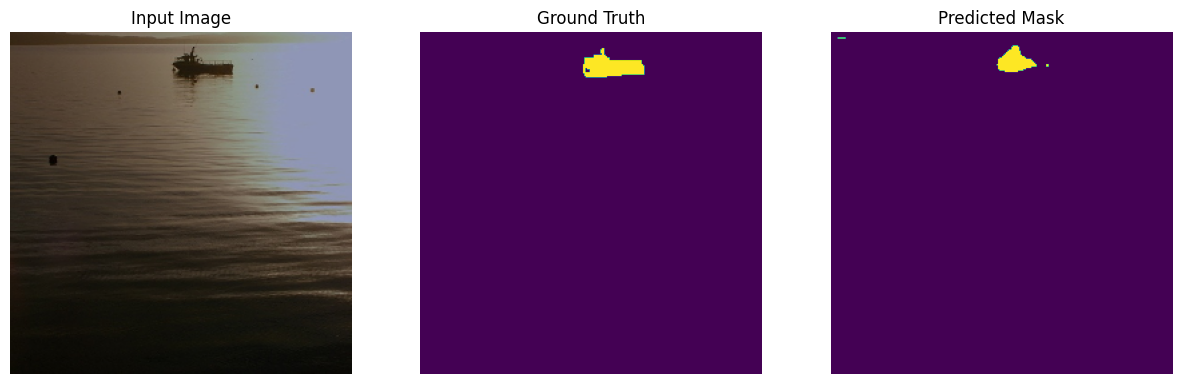

background
person


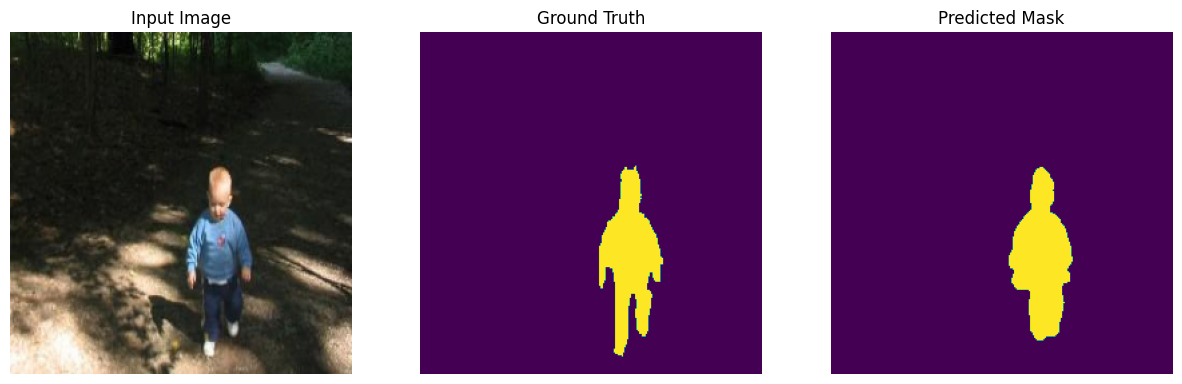

background
chair
potted plant
sofa


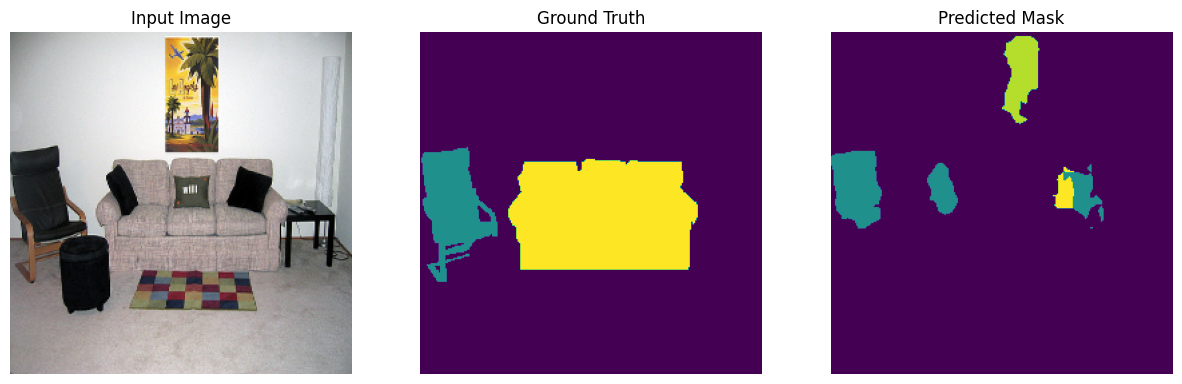

background
bus


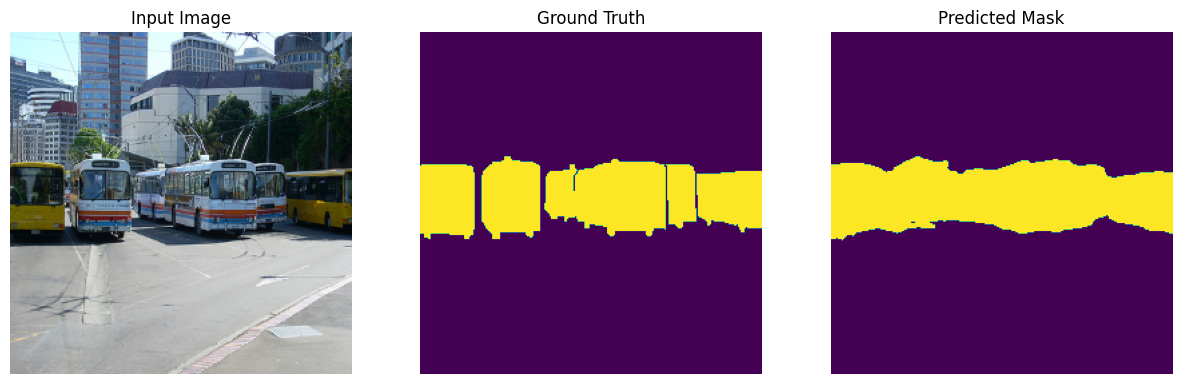

background
aeroplane


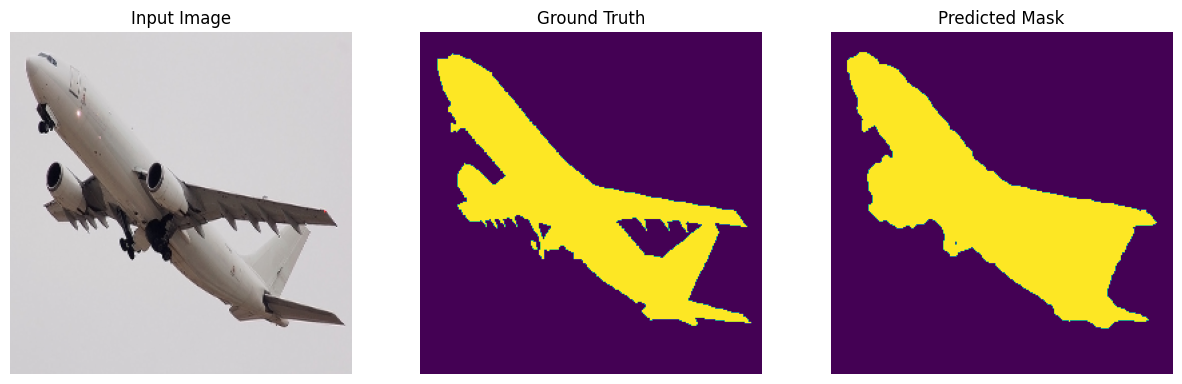

In [16]:
for i in range(15):
    # Randomly select an image and its ground truth from the test dataset
    id = random.randint(0, len(test_dataset) - 1)
    
    with torch.no_grad():
        model.eval()
        x, y = test_dataset.__getitem__(id)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y_predict = model(x).argmax(dim=1).squeeze().cpu().numpy()  # Get predicted mask (2D array)
        
        # Print class labels for the predicted mask (if any)
        for class_id in np.unique(y_predict):
            print(VOC_CLASSES[class_id])

    # Convert the input image to a numpy array for visualization (if it's a tensor)
    x = x.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for RGB
    
    # Convert ground truth (if y is one-hot encoded, apply argmax to get the class labels)
    ground_truth = y.squeeze().cpu().numpy()  # (H, W, 21) -> (H, W)
    ground_truth = np.argmax(ground_truth, axis=-1)  # Apply argmax to reduce to (H, W)
    
    # Define the mean and std values used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Unnormalize: multiply by std and add mean for each channel
    unnormalized_image = x * std + mean  # Unnormalize the image

    # Clip values to [0, 1] to make sure they are within the valid range for displaying
    unnormalized_image = np.clip(unnormalized_image, 0, 1)
    
    # Plot the input image, ground truth, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image (unnormalized)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth (2D array with class labels)
    axes[1].imshow(ground_truth)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    # Predicted Mask (2D array with class labels)
    axes[2].imshow(y_predict)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()
